# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

In [2]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 2, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = [1.0; rand(-0.03:0.06:0.03, p-1)]
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)

    # simulate design matrices
    Random.seed!(seed)
    X_full = Matrix{Float64}[]
    for i in 1:n
        nobs = rand(1:d) # number of obs for this sample
        push!(X_full, hcat(ones(nobs), randn(nobs, p - 1)))
    end

    # simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, size(X, 1))
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            vecd = Vector{DiscreteUnivariateDistribution}(undef, size(X, 1))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Bernoulli
  * link function: LogitLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [3]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 200,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

In [26]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [1.0, -0.03, 0.03]
qc_model.β = [0.9787109971992247, -0.006534895264500844, 0.004756529558569876]
qc_model.∇β = [-1.2530390755549625e-6, 8.717288488488406e-7, -9.137386014490545e-7]
θtrue = [0.1, 0.1]
qc_model.θ = [0.09068628793643643, 0.050371173525735724]
qc_model.∇θ = [1.0514365018088334e-6, 9.835424232274015e-7]


## Score test: compare to autodiff result

In [102]:
# autodiff
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

R = 4.699396265227433
Q = 204.3473819980191
W = [0.9061362858752553, 1.2241966728428746, -1.8025715207298199, 26.91134972056205, -3.0222135065035567]
R = 21.412671844862153
Q = 249.3074295630108
W = [2.95423970103876, -5.511143050277906, 3.2916983270210234, 70.76534097790865, 6.512344053444019]


LoadError: UndefVarError: fdsa not defined

In [104]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

R = 4.699396265227423
Q = 204.3473819980169
W = [0.9061362858752758, 1.2241966728428944, -1.8025715207297885, 26.911349720562043, -3.022213506503561]
R = 21.412671844862075
Q = 249.30742956301185
W = [2.9542397010388366, -5.511143050277937, 3.2916983270210323, 70.76534097790869, 6.512344053444009]


LoadError: UndefVarError: fdsa not defined

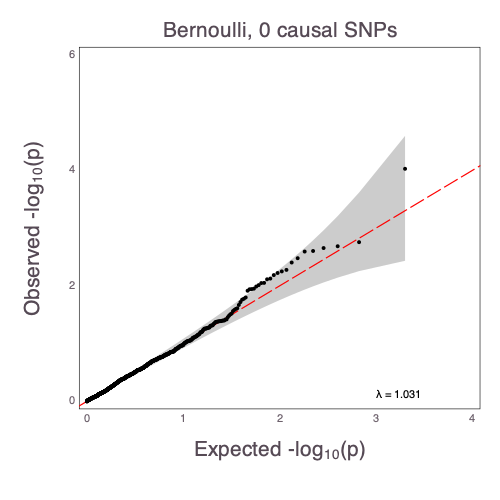

In [86]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [6]:
# 2 Hessian terms with VCs included
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, num_Hessian_terms=2)

R = 4.699396265227423
Q = 352.0337921192098
W = [0.40638550002021223, 2.542822133793875, -0.5803039943342727, 26.911349720562043, -3.022213506503561]
Pinv = [0.0006610997551383955 -2.8612889453814105e-6 5.999253906699741e-6 0.00015820831575871856 0.0005974366955573677; -2.8612889453814105e-6 0.0003208241917204654 2.555496506744759e-7 -1.4304020911006004e-6 -2.73572175496455e-6; 5.999253906699743e-6 2.555496506744736e-7 0.0003220621555815002 3.004376999196446e-6 7.0749790960273215e-6; 0.0001582083157587186 -1.4304020911006006e-6 3.004376999196446e-6 0.0001744713082017632 0.00015662346595715453; 0.0005974366955573677 -2.73572175496455e-6 7.07497909602732e-6 0.0001566234659571545 0.0011000953731697442]


LoadError: UndefVarError: fff not defined

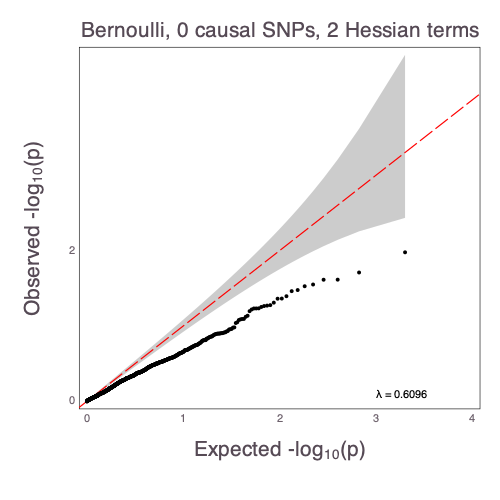

In [104]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 2 Hessian terms")
display("image/png", read("qqplot.png"))

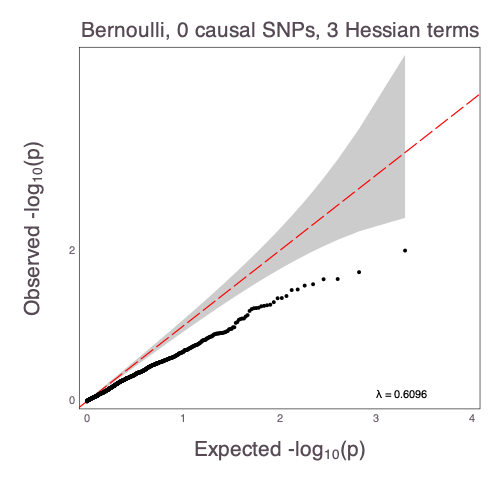

In [97]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

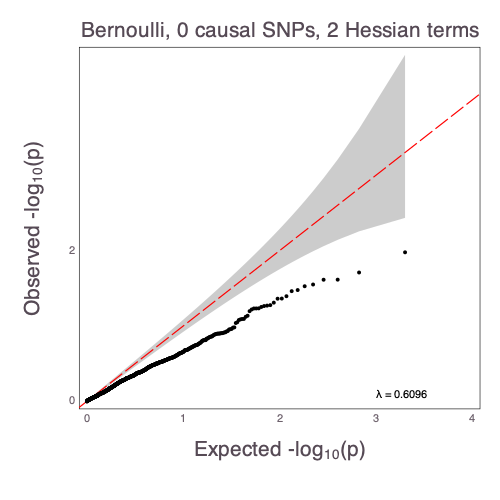

In [67]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 2 Hessian terms")
display("image/png", read("qqplot.png"))